In [1]:
"""Data inspection."""

'Data inspection.'

In [2]:
import glob
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
import nibabel
import os
import sklearn

import torch
import numpy as np
import pickle
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, FloatSlider
import ipywidgets as widgets

NEUROPATH = '/neuro/train_test_datasets'
PATH = '/scratch/users/nmiolane/output'
DEVICE='cuda'

In [2]:
nii = nibabel.load('/neuro/boldscans/processed/ses-003/sub-01_ses-003_task-rest_run-001_bold.nii.gz')
array = nii.get_fdata()
array = np.nan_to_num(array)
print(array.shape)
print(nii.header)

(128, 128, 52, 448)
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 57
dim             : [  4 128 128  52 448   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.     2.     2.     1.998  1.2    1.     1.     1.   ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.003436106
quatern_c       : -0.99477684
quatern_d       : -0.10193608
qoffset_x       : 132.09444
qoffset_y       :

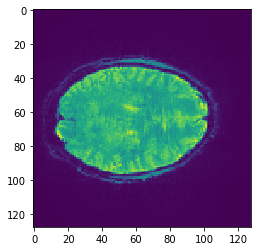

In [3]:
plt.figure()
plt.imshow(array[:, :, 26, 447], cmap='viridis')

(128, 52, 448)


NameError: name 'HTML' is not defined

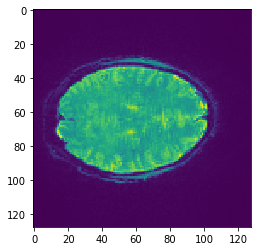

In [8]:
mat = array
print(mat[0].shape)
slice = 26
def quick_play(dT = 50):
    fig, ax = plt.subplots()
    im = ax.imshow(mat[:, :, slice, 0], cmap = 'viridis')

    def init():
        im.set_data(mat[:, :, slice, 0])
        return im,

    def animate(i):
        im.set_data(mat[:, :, slice, i])
        return im,

    anima = animation.FuncAnimation(
        fig, animate, frames = array.shape[3]-1, init_func = init, interval = dT, blit = True)
    return anima
    #plt.show()

anima = quick_play()
HTML(anima.to_html5_video())

### Inspect MakeDataset

(2688, 1, 64, 64)
(4032, 1, 64, 64)


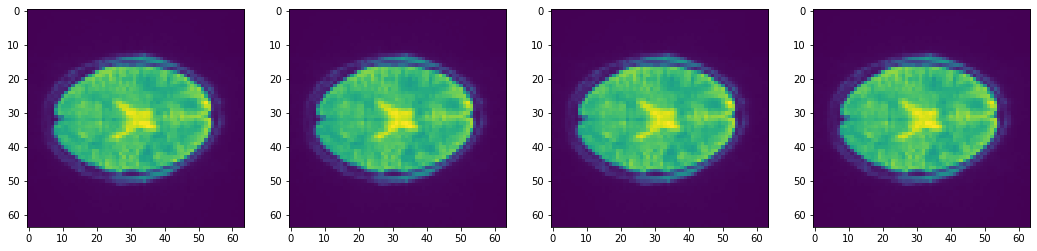

In [7]:
directory = '/neuro/train_test_datasets'
train = np.load(f'{directory}/train_fmri_64x64.npy')
test = np.load(f'{directory}/test_fmri_64x64.npy')
print(train.shape)
print(test.shape)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))
for i, img in enumerate(train):
    if i > 3: break
    ax = axes[i]
    ax.imshow(img[0], cmap='viridis')

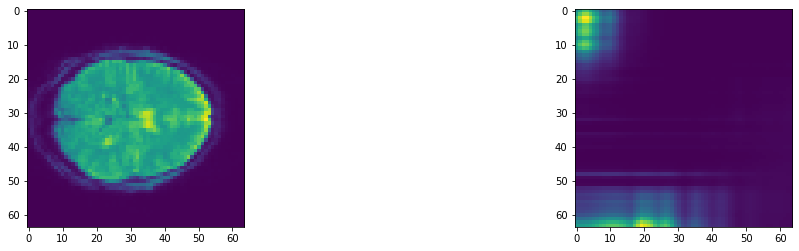

In [43]:
epoch_id = 2
data = np.load('/scratch/users/nmiolane/output/training/imgs/epoch_%d_data.npy' % epoch_id)
recon = np.load('/scratch/users/nmiolane/output/training/imgs/epoch_%d_recon.npy' % epoch_id)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
ax = axes[0]
ax.imshow(data[0, 0], cmap='viridis')
ax = axes[1]
ax.imshow(recon[0, 0], cmap='viridis')

### Inspect training

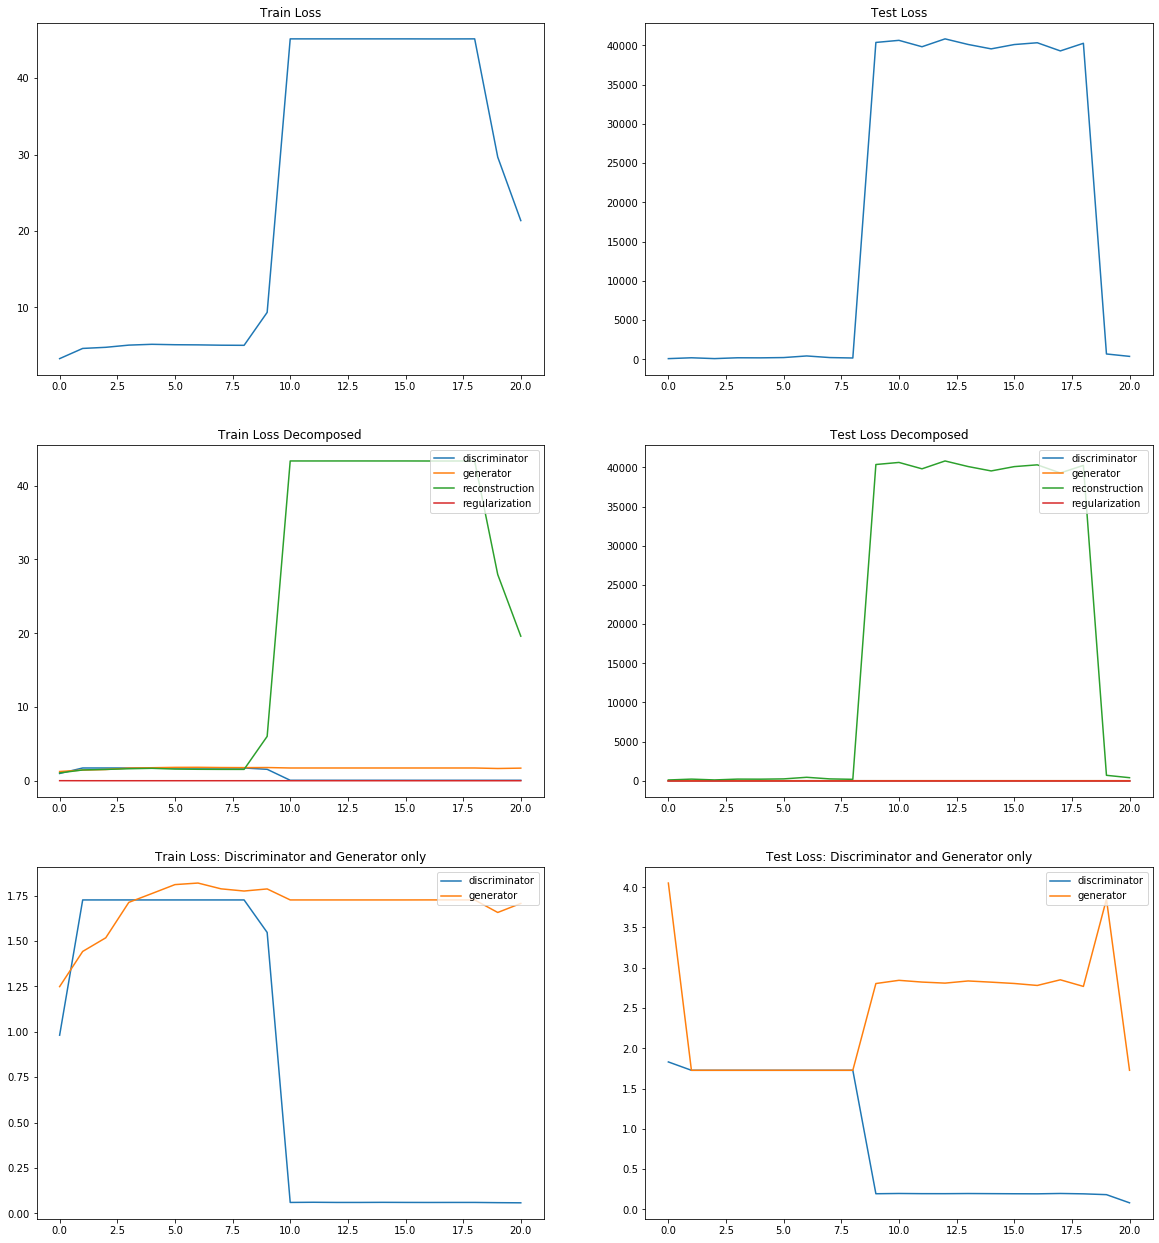

In [19]:
n_epoch = 20

loss_types = [
    'total',
    'discriminator', 'generator',
    'reconstruction', 'regularization']
train_losses = {loss_type: [] for loss_type in loss_types}
test_losses = {loss_type: [] for loss_type in loss_types}

for i in range(n_epoch+1):
    train_test = pickle.load(open(f'{PATH}/training/losses/epoch_{i}.pkl', 'rb'))
    train = train_test['train']
    test = train_test['val']

    for loss_type in loss_types:
        loss = train[loss_type]
        train_losses[loss_type].append(loss)
        
        loss = test[loss_type]
        test_losses[loss_type].append(loss)

n_rows = 3
n_cols = 2
fig = plt.figure(figsize=(20, 22))

# Total
plt.subplot(n_rows, n_cols, 1)
plt.plot(train_losses['total'])
plt.title('Train Loss')

plt.subplot(n_rows, n_cols, 2)
plt.plot(test_losses['total'])
plt.title('Test Loss')

# Decomposed in sublosses
epochs = range(n_epoch+1)

plt.subplot(n_rows, n_cols, 3)
plt.plot(epochs, train_losses['discriminator'])
plt.plot(epochs, train_losses['generator'])
plt.plot(epochs, train_losses['reconstruction'])
plt.plot(epochs, train_losses['regularization'])

plt.title('Train Loss Decomposed')
plt.legend(
    [loss_type for loss_type in loss_types if loss_type != 'total'], 
    loc='upper right')

plt.subplot(n_rows, n_cols, 4)
plt.plot(epochs, test_losses['discriminator'])
plt.plot(epochs, test_losses['generator'])
plt.plot(epochs, test_losses['reconstruction'])
plt.plot(epochs, test_losses['regularization'])

plt.title('Test Loss Decomposed')
plt.legend(
    [loss_type for loss_type in loss_types if loss_type != 'total'], 
    loc='upper right')

# Only Discriminator and Generator
plt.subplot(n_rows, n_cols, 5)
plt.plot(epochs, train_losses['discriminator'])
plt.plot(epochs, train_losses['generator'])
plt.title('Train Loss: Discriminator and Generator only')
plt.legend(
    [loss_type for loss_type in loss_types 
     if loss_type == 'discriminator' or loss_type == 'generator'], 
    loc='upper right')

plt.subplot(n_rows, n_cols, 6)
plt.plot(epochs, test_losses['discriminator'])
plt.plot(epochs, test_losses['generator'])
plt.title('Test Loss: Discriminator and Generator only')
plt.legend(
    [loss_type for loss_type in loss_types 
     if loss_type == 'discriminator' or loss_type == 'generator'], 
    loc='upper right')

# 2. Inspect the latent space

## Standard PCA on the means of the approximation of the posterior

### Load test set and compute latent codes

In [30]:
from sklearn.decomposition import PCA
N_COMPONENTS = 5

# epoch_id = 120
# encoder = load_model('encoder', epoch_id)

encoder = load_last_model('encoder')

test = np.load('/neuro/train_val_datasets/val_fmri_64x64.npy')
print(test.shape)
test = torch.Tensor(test)
test_dataset = torch.utils.data.TensorDataset(test)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=True)

Last checkpoint:  /scratch/users/nmiolane/output/training/models/epoch_20_encoder_train_loss_21.3628_val_loss_388.6711.pth
(32634, 1, 64, 64)


In [31]:
# Euclidean PCA on the Gaussian means learnt by the model
mus = []
for i, data in enumerate(test_loader):
    data = data[0].to(DEVICE)
    mu, logvar = encoder(data)
    mus.append(np.array(mu.cpu().detach()))

mus = np.array(mus).squeeze()
print(mus.shape)

pca = PCA(n_components=N_COMPONENTS)
pca.fit(mus)
print(mus.shape)
projected_mus = pca.transform(mus)
print(mus.shape)

(32634, 50)
(32634, 50)
(32634, 50)


## Gaussian Kernel Density Estimation

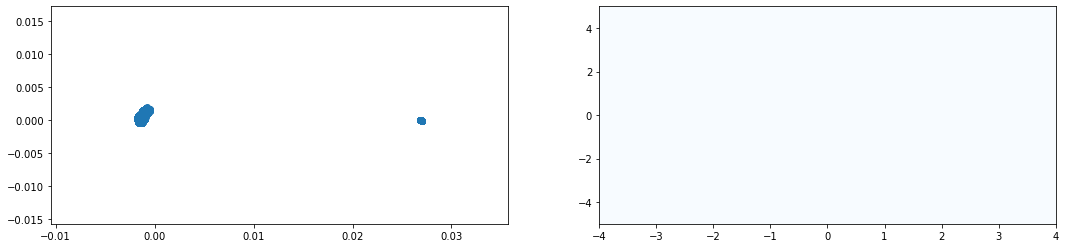

In [32]:
from scipy.stats import gaussian_kde


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
ax = axes[0]
ax.scatter(projected_mus[:, 0], projected_mus[:, 1])

ax = axes[1]

x = projected_mus[:, 0]
y = projected_mus[:, 1]
data = np.vstack([x, y])
kde = gaussian_kde(data)

# evaluate on a regular grid
xgrid = np.linspace(-4, 4, 200)
ygrid = np.linspace(-5, 5, 200)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))

# Plot the result as an image
ax.imshow(Z.reshape(Xgrid.shape),
           origin='lower', aspect='auto',
           extent=[-4, 4, -5, 5],
           cmap='Blues')
#cb = plt.colorbar()
#cb.set_label("density")

# for i in range(N_COMPONENTS):
#    mus = projected_mus[:,i]
#    print(np.std(mus))
#    plt.subplot(n_rows, n_cols, i+3)
#    plt.hist(mus, bins='auto')


## Fit a Gaussian Mixture

INFO:root:Found 106 sessions of rfMRIs: Divide in 75 train, 21 val and 10 test sessions

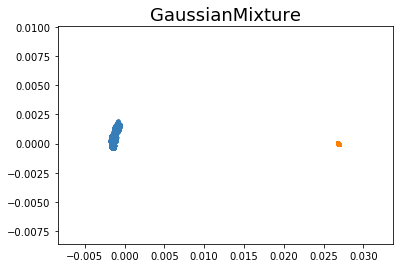

In [38]:
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

# Clustering
X = projected_mus
n_components = 5

#X = StandardScaler().fit_transform(X)
gmm = mixture.GaussianMixture(
    n_components=n_components, covariance_type='full')
algorithm = gmm
name = 'GaussianMixture'
    
algorithm.fit(X)

if hasattr(algorithm, 'labels_'):
    print('test')
    y_pred = algorithm.labels_.astype(np.int)
else:
    y_pred = algorithm.predict(X)

fig, ax = plt.subplots(1, 1)
ax.set_title(name, size=18)

colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                     '#f781bf', '#a65628', '#984ea3',
                                      '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
# add black color for outliers (if any)
colors = np.append(colors, ["#000000"])
ax.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

#ax.xlim(-4, 4)
#ax.ylim(-5, 5)
#ax.xticks(())
#ax.yticks(())

plt.show()

### Interactive exploration of PCA in each cluster

In [26]:
print(torch.__version__)

1.1.0


In [40]:
epoch_id = 20

stds = np.zeros(N_COMPONENTS)
for i in range(N_COMPONENTS):
    stds[i] = np.std(projected_mus[:,i])
    
decoder = load_model('decoder', epoch_id)


projected = {}
pcas = {}
for i in range(n_components):
    print('Cluster: %d' % i)
    cluster = mus[y_pred==i]
    pca = PCA(n_components=N_COMPONENTS)
    pca.fit(cluster)
    projected[i] = pca.transform(cluster)
    pcas[i] = pca

    @interact(
        c1=FloatSlider(min=-3,max=3,step=0.1,value=0), 
        c2=FloatSlider(min=-3,max=3,step=0.1,value=0),
        c3=FloatSlider(min=-3,max=3,step=0.1,value=0),
        c4=FloatSlider(min=-3,max=3,step=0.1,value=0),
        c5=FloatSlider(min=-3,max=3,step=0.1,value=0))
    def display_image(c1, c2, c3, c4, c5):
        z = (c1 * pca.components_[0]
             + c2 * pca.components_[1]
             + c3 * pca.components_[2]
             + c4 * pca.components_[3]
             + c5 * pca.components_[4])
        z = torch.Tensor(z).cuda()
        recon, _ = decoder(z)
        recon = recon.squeeze()
        plt.imshow(recon.detach().cpu(), cmap='afmhot')

Loading: /scratch/users/nmiolane/output/training/models/epoch_20_decoder_train_loss_21.3628_val_loss_388.6711.pth
Cluster: 0


interactive(children=(FloatSlider(value=0.0, description='c1', max=3.0, min=-3.0), FloatSlider(value=0.0, desc…

Cluster: 1


interactive(children=(FloatSlider(value=0.0, description='c1', max=3.0, min=-3.0), FloatSlider(value=0.0, desc…

Cluster: 2


ValueError: Found array with 0 sample(s) (shape=(0, 50)) while a minimum of 1 is required.

### PCA in each cluster

In [28]:
fig = plt.figure(figsize=(20, 50))
plt.tight_layout()
r = 4
n_cols = 2 * r + 1 

projected = {}
pcas = {}
cmaps = ['Blues', 'Purples', 'Greens', 'Oranges', 'Reds']
for i in range(n_clusters):
    cluster = mus[y_pred==i]
    pca = PCA(n_components=N_COMPONENTS)
    pca.fit(cluster)
    projected[i] = pca.transform(cluster)
    pcas[i] = pca

    for id in range(N_COMPONENTS):
        for slider in range(-r, r+1, 1):
            plt.subplot(n_clusters*N_COMPONENTS, n_cols, i * N_COMPONENTS * n_cols + id * n_cols + slider + r + 1)
            z = slider * pca.components_[id]
            z = torch.Tensor(z).cuda()
            recon, _ = decoder(z)
            recon = recon.squeeze()
            plt.imshow(recon.detach().cpu(), cmap=cmaps[i])

NameError: name 'n_clusters' is not defined

<Figure size 1440x3600 with 0 Axes>

# 3. Inspect report created by pipeline

In [49]:
import os
import pylab

report_dir = '/scratch/users/nmiolane/output/report'
losses_path = os.path.join(report_dir, 'losses.png')
images_path = os.path.join(report_dir, 'images.png')
report_path = os.path.join(report_dir, 'report.html')

plt.figure()
img = pylab.imread(losses_path)
plt.imshow(img, aspect='auto')
plt.axis('off')

plt.figure(figsize=(30, 60))
img = pylab.imread(images_path)
plt.imshow(img)
plt.axis('off')


FileNotFoundError: [Errno 2] No such file or directory: '/scratch/users/nmiolane/output/report/losses.png'

<Figure size 432x288 with 0 Axes>

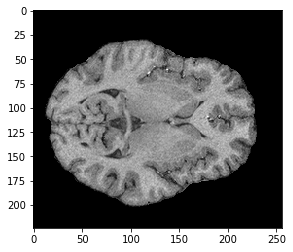

In [3]:
import nibabel
path = '/tmp/_oyiw_36_defBrainExtractionBrain.nii.gz'
img = nibabel.load(path)
array = img.get_fdata()
array = np.nan_to_num(array)
plt.imshow(array[:,:,120], cmap='gray')